# 4 Channel Input and Multi-label Binary Cross Entropy

My intent in this notebook is to get a working model of resnet 50 with a 4 channel image instead of a merged RGBY$\to$RGB image.

We can also add a normalize transform to the dataset transformer.

Then gain further manipulation of the loss model, refactor the training loop into a less verbose function.

Then use our training set to actually provide an appropiate evalutaiton metric, rather than accuracy.

In [110]:
# imports
import pandas as pd
from PIL import Image
import random
import matplotlib.pyplot as plt
import numpy as np
import glob

# transformers
from torchvision import transforms
from skimage.transform import rescale, resize, downscale_local_mean

# dataset imports
import os
import torch
import torch.utils.data
import torchvision
import torch
import torch.nn as nn

# model imports
import copy

# evaluation imports
import time
from sklearn import metrics

## 4 Channel Image Input

In notebook 2_training we used a RGB input into our ResNet50. this however involved merging 4 channels into 3 and therefore losing information. Since the training loop only inputs one image at a time into the model. 

PyTorch modules processing image data expect tensors in the format C × H × W

Whereas PILLow and Matplotlib expect image arrays in the format H × W × C

We can permute the image array if wanted.

### ResNet50
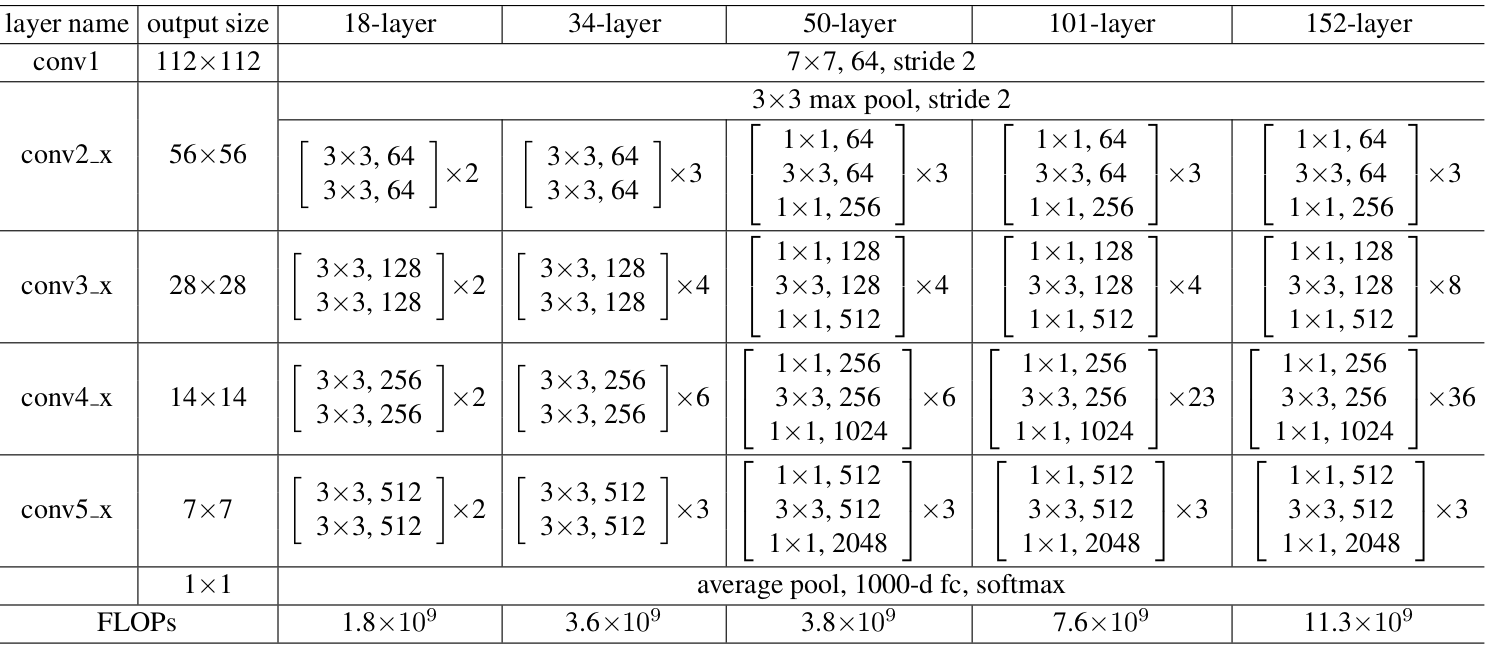
***From [https://iq.opengenus.org/resnet50-architecture/]***

In [147]:
# model 
model = torchvision.models.resnet50()

In [148]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

The ResNet50 architcture is shown above. It shows the first layer being conv1. A [Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) with parameters:

torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')


We can see that changing the in_channels has no affect on the out channels. To prove this.

In [149]:
# Fake 3 channel
m = nn.Conv2d(3, 64, (7, 7), stride=(2,2), padding=(3,3), bias=False)

inp = torch.rand(1, 3, 224, 224)
output = m(inp)
print(output.shape)

torch.Size([1, 64, 112, 112])


In [150]:
# Fake 4 channel
m = nn.Conv2d(4, 64, (7, 7), stride=(2,2), padding=(3,3), bias=False)

inp = torch.rand(1, 4, 224, 224)
output = m(inp)
print(output.shape)

torch.Size([1, 64, 112, 112])


So to continue we need to change the initial Conv1 to be Conv2d(4, 64, (7, 7), stride=(2,2), padding=(3,3), bias=False).

Also while we are here, let's change the fully connected layers to be an input of 2048 features and an output of 19 for the multi-label problem.

In [151]:
model.conv1 = nn.Conv2d(4, 64, (7, 7), 
                        stride=(2,2), 
                        padding=(3,3), 
                        bias=False)

# output features to 3 classification
model.fc = torch.nn.Sequential(
    torch.nn.Linear(
        in_features=2048,
        out_features=19
    ),
    torch.nn.Sigmoid()
)

In [152]:
model

ResNet(
  (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Dataset

#### Transformers
Since we are no longer merging the tiles into a 4 channel image. We now need to operate by:
1. receiving the idx 
2. splitting the masks
3. masking each channel to segments
4. rescale each channel segemnet to 224
5. normalize
6. tensor

Let's load one image, and try it out.

In [48]:
df = pd.read_csv('../input/train.csv')
df.head(1)

,ID,Label
0,5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0,8|5|0


In [49]:
# Transform string label to 19 one-hot columns
cols = [str(i) for i in list(range(19))]
df[cols] = np.nan

# Apply mapping
def encoder(row):
    labels = row['Label'].split('|')
    for label in labels:
        row[label] = 1    
    return row

df = df.apply(encoder, axis=1)
df.fillna(0, inplace=True)

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21806 entries, 0 to 21805
Data columns (total 21 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      21806 non-null  object 
 1   Label   21806 non-null  object 
 2   0       21806 non-null  float64
 3   1       21806 non-null  float64
 4   2       21806 non-null  float64
 5   3       21806 non-null  float64
 6   4       21806 non-null  float64
 7   5       21806 non-null  float64
 8   6       21806 non-null  float64
 9   7       21806 non-null  float64
 10  8       21806 non-null  float64
 11  9       21806 non-null  float64
 12  10      21806 non-null  float64
 13  11      21806 non-null  float64
 14  12      21806 non-null  float64
 15  13      21806 non-null  float64
 16  14      21806 non-null  float64
 17  15      21806 non-null  float64
 18  16      21806 non-null  float64
 19  17      21806 non-null  float64
 20  18      21806 non-null  float64
dtypes: float64(19), object(2)
memory us

In [51]:
# OHE labels
np.array(df.iloc[0, 2:].to_numpy(dtype='float16'))

array([1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.], dtype=float16)

In [52]:
class Tile(object):
    """
    Takes in:
    imgs = {
            'red': Image.open(r_path),
            'green': Image.open(g_path),
            'blue': Image.open(b_path),
            'yellow': Image.open(y_path),
            'mask': Image.open(mask_path)
        }
    
    target = {
        'image_id': torch.tensor([idx]),
        'labels': np.array(df.iloc[idx, 3:])
    }
    Outputs:
    
    imgs = {
            'tiles': tiles
        }
        
    target = {
        'image_id': torch.tensor([idx]),
        'labels': np.array(df.iloc[idx, 3:])
    }
    """
    @staticmethod
    def tiled_img(r, g, b, y, box):
        """
        Find center of box. Crop the image using PIL
        at center, using desired tile size.
        """
        # (xmax-xmin) / 2 , (ymax - ymin) /2
        center = ( (box[2]-box[0])/2, (box[3]-box[1])/2 )
        left = box[0]
        top = box[1]
        right = box[2]
        bottom = box[3]
        
        # crop channels
        r = r.crop((left, top, right, bottom))
        g = g.crop((left, top, right, bottom))
        b = b.crop((left, top, right, bottom))
        y = y.crop((left, top, right, bottom))
        
        # return cropped channels using PIL 
        rgby = np.dstack((r,g,b,y))
    
        return(rgby)
    
    
    @staticmethod
    def split_mask(mask):
        # convert to array for individual segments
        mask = np.array(mask)
        # split into different segmentations
        obj_ids = np.unique(mask)
        # 0 is background, get rid
        obj_ids = obj_ids[1:]
        
        # split color-encoded mask into
        # a set of binary masks
        
        masks = mask == obj_ids[:, None, None] # HOW DOES THIS WORK
        
        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])
        return boxes
        
        
    @staticmethod
    def gen_labels(labels, num_objs):
        """
        Take in numpy array of one hot encoded labels
        output:
        [N, OHE labels]
        where N is the number of objects or tiles
        """
        return [labels for i in range(num_objs)]
        
        
    def __call__(self, sample):
        imgs, target = sample
        
        # get masks
        boxes = self.split_mask(imgs['mask'])
         
        # list of tiled imgs
        tiles = list()
        for box in boxes:
            tiles.append(self.tiled_img(imgs['red'],
                                        imgs['green'],
                                        imgs['blue'],
                                        imgs['yellow'],
                                        box))
            
        # target
        new_target = {
        'image_id': target['image_id'],
        'labels': self.gen_labels(target['labels'], len(boxes))
        }
        
        
        return ((tiles, new_target))

In [53]:
class Rescale(object):
    """
    Rescale the tiles received.
    Return rescaled 4 channel images (numpy)
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple)) # check output size is 
                                                     # right format
        self.output_size = output_size

    def __call__(self, sample):
        
        imgs, target = sample
        for i in range(len(imgs)):
            # numpy.shape responds with (H, W, C)
            h = imgs[i].shape[0] 
            w = imgs[i].shape[1] 

            if isinstance(self.output_size, int):
                if h > w:
                    new_h, new_w = self.output_size * h / w, self.output_size
                else:
                    new_h, new_w = self.output_size, self.output_size * w / h
            else:
                new_h, new_w = self.output_size

            new_h, new_w = int(new_h), int(new_w)

            #resize iamge
            imgs[i] = resize(imgs[i], 
                             (new_h, new_w))
        return ((imgs, target))


In [54]:
class ImageToTensor(object):
    """
    Custom to tensor class, does not accept dictionary.
    """

    @staticmethod
    def image_tensor(imgs):
        return [torch.from_numpy(im).permute(2,0,1) for im in imgs]
    
    
    @staticmethod
    def idx_tensor(idx):
        return torch.tensor(idx)
    
    
    @staticmethod
    def labels_tensor(labels):
        return[torch.from_numpy(l) for l in labels]
    
    
    def __call__(self, sample):
        imgs, target = sample
        # torch image: C X H X W
        t_tiles = self.image_tensor(imgs)
        idx = self.idx_tensor(target['image_id'])
        labels = self.labels_tensor(target['labels'])
        
        new_target = {
            'image_id': idx,
            'labels': labels
        }
        return ((t_tiles, new_target))

In [55]:
class Normalize_tiles(object):
    """
    
    Currently inactive, need help on this
    
    Takes in tiles (tensor)
    we need to permute in this transformation
    the permutations takes about 1-2s so it is quite costly
    Returns normalized version of tiles (tensor)
    """
    def __init__(self, mean=(0.485, 0.456, 0.406, 0.406),
                std=(0.229, 0.224, 0.225, 0.225)):
        self.mean = mean
        self.std = std
    
    def __call__(self, sample):
        imgs, target = sample
        norm = transforms.Normalize(self.mean, self.std)
                        
        n_tiles = [norm(im.permute(2,0,1)) for im in imgs]

        return ((n_tiles, target))

In [56]:
class HPAImageDataset(object):
    
    
    def __init__(self, root, transforms, df):
        self.root = root
        self.df = df
        self.transforms = transforms
 

    def __len__(self):
        return(len(self.df))
                          
    
    def __getitem__(self, idx):
        # load channels and masks for idx
        r_path = os.path.join(self.root, "image", 
                              self.df.ID[idx]+'_red.png')
        g_path = os.path.join(self.root, "image", 
                              self.df.ID[idx]+'_green.png')
        b_path = os.path.join(self.root, "image", 
                              self.df.ID[idx]+'_blue.png')
        y_path = os.path.join(self.root, "image", 
                              self.df.ID[idx]+'_yellow.png')
        
        mask_path = os.path.join(self.root, 
                                 "mask", 
                                 self.df.ID[idx]+'_predictedmask.png')

        # open imgs in PIL
        imgs = {
            'red': Image.open(r_path),
            'green': Image.open(g_path),
            'blue': Image.open(b_path),
            'yellow': Image.open(y_path),
            'mask': Image.open(mask_path)
        }
    
        #define target
        target = {
            'image_id': idx,
            'labels': df.iloc[0, 2:].to_numpy(dtype='float16')
        }
        
        if self.transforms is not None:
            # torchvision compose only accepts single input
            sample = self.transforms((imgs, target))
            imgs, target = sample
        # return((imgs, target))  if we want to include imge ID
        return((imgs, target['labels']))  

In [57]:
# define transforms
def get_transform():
    custom_transforms = [Tile(), Rescale((224,224)), 
                         ImageToTensor()]
    return torchvision.transforms.Compose(custom_transforms)

In [58]:
ROOT_DIR = '../input/image_subset/'

# create own Dataset
transformed_dataset = HPAImageDataset(root=ROOT_DIR,
                          transforms=get_transform(),
                          df=df,
                          )

In [59]:
# single tiled output
transformed_dataset[0][0][0].shape

torch.Size([4, 224, 224])

In [60]:
# number of cols
transformed_dataset[0][1][0].shape

torch.Size([19])

In [61]:
def collate_fn(batch):
    anno = []
    tiles = []
    for b in batch:
        for label in b[1]:
            anno.append(label)
        for tile in b[0]:
            tiles.append(tile)
    return tuple(zip(tiles, anno))

In [62]:
# set train val split

"""
Stratified K Folding would be better.
"""
# how much of the dataset do you want to train on
subset_dataset = torch.utils.data.Subset(transformed_dataset, 
                                        list(range(0, 1000)))
split = int(0.8 * len(subset_dataset))

# batch size
batch_s = 1

# train dataset & dataloader
dataset_train = torch.utils.data.Subset(subset_dataset, 
                                        list(range(0,split)))

train_loader = torch.utils.data.DataLoader(dataset_train,
                                          batch_size=batch_s,
                                          shuffle=True, collate_fn=collate_fn)

# test dataset & dataloader
dataset_test = torch.utils.data.Subset(subset_dataset,
                                     list(range(split, len(subset_dataset))))
test_loader = torch.utils.data.DataLoader(dataset_test,
                                          batch_size=1,
                                          shuffle=False, collate_fn=collate_fn)
print(len(dataset_train))
print(len(dataset_test))

dataloaders = {
    "train": train_loader,
    "test": test_loader
}

800
200


In [63]:
single_batch = next(iter(train_loader))
single_batch[0][0].shape
single_batch[0][1].shape

torch.Size([19])

This Image has label: tensor([1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.], dtype=torch.float16)


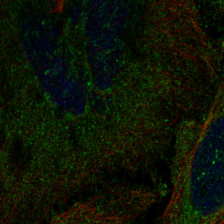

In [64]:
print('This Image has label: {}'.format(single_batch[0][1]))
# sigle_batch[img ro label][img_n][tile_n]
(transforms.ToPILImage(mode='RGB')(single_batch[0][0][:3, :, :]))

# Model Training

In [65]:
if len(train_loader) * batch_s == len(dataset_train):
    print('Setup is correct')

Setup is correct


In [142]:
# Config

USE_GPU = False
EPOCHS = 1

optimizer = torch.optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()

In [67]:
def loss_function(y, labels):
    loss = criterion(y, labels.float())
    return loss

In [68]:
def train_test(dataloaders, optimizer, criterion, model):
    if USE_GPU:
        model = model.cuda() # Should be called before instantiating optimizer according to docs: https://pytorch.org/docs/stable/nn.html
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # logs
    log_loss = list()
    log_acc = list()

    # test
    test_pred = []
    test_true = []

    for i in range(EPOCHS):

        for phase in ["train", "test"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            samples = 0
            loss_sum = 0
            correct_sum = 0

            for j, batch in enumerate(dataloaders[phase]):

                # for tiles in batch
                for k in range(len(batch)):

                    # define X and y
                    X = batch[k][0].unsqueeze(0).float() # model requires tensor stack
                                                 # [N, C, W, H]
                    labels = torch.reshape(batch[k][1], (1,19))
                                                # [N, 19]

                    if USE_GPU:
                        X = X.cuda()
                        labels = labels.cuda()

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        y = model(X)

                        if phase == "test":
                            test_pred.extend(y.squeeze().numpy())
                            test_true.extend(labels.float().squeeze().numpy())

                        loss = loss_function(y, labels)

                        if phase == "train":
                            loss.backward()
                            optimizer.step()

                        loss_sum += loss.item() * 1 # always one input to model
                        samples += 1 # always one input into model
                        num_corrects = torch.sum((y >= 0.5).float() == labels.float())
                        correct_sum += num_corrects

                # Print image statistics every 100 images
                if j % 100 == 0 and phase == "train":
                    loss = float(loss_sum) / float(samples)
                    acc = float(correct_sum) / float(samples*19) # 19 classes per sample

                    # log values (probably a PyTorch way to do this)
                    log_loss.append(loss)
                    log_acc.append(acc)

                    print("{}:{} - loss: {}, acc: {}".format(
                        i, 
                        j, 
                        loss, 
                        acc
                    ))

            # Print epoch statistics
            epoch_acc = float(correct_sum) / float(samples*19)
            epoch_loss = float(loss_sum) / float(samples)
            print("epoch: {} - {} loss: {}, {} acc: {}".format(i + 1, phase, epoch_loss, phase, epoch_acc))

            # Deep copy the model
            if phase == "test" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(best_model_wts, "resnet50.pth")
    
    return(log_loss, log_acc, test_pred, test_true)

In [69]:
t1 = time.time()
log_loss, log_acc, test_pred, test_true = train_test(dataloaders, 
                                                     optimizer, 
                                                     criterion, 
                                                     model)
t2 = time.time()

print("Training took {} seconds".format((t2-t1)))

0:0 - loss: 0.6622030138969421, acc: 0.956140350877193
0:100 - loss: 0.6333008857031377, acc: 0.9997951281473438
0:200 - loss: 0.6332366494736711, acc: 0.9998921484037964
0:300 - loss: 0.633214930460998, acc: 0.9999249514060354
0:400 - loss: 0.6332019956136301, acc: 0.9999444873125752
0:500 - loss: 0.633194699857007, acc: 0.9999555063158785
0:600 - loss: 0.6331899795497697, acc: 0.9999626355395802
0:700 - loss: 0.6331866113931639, acc: 0.9999677225690253
epoch: 1 - train loss: 0.6331842474463046, train acc: 0.9999712929099229
epoch: 1 - test loss: 0.6331652403896473, test acc: 1.0
Training took 8661.640503883362 seconds


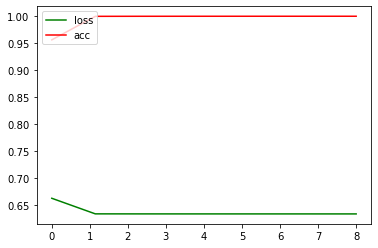

In [70]:
# plot loss and acc throughout
fig, ax = plt.subplots()
axis_x = np.linspace(0, len(log_loss), len(log_loss))
ax.plot(axis_x , log_loss, color = 'green', label = 'loss')
ax.plot(axis_x , log_acc, color = 'red', label = 'acc')
ax.legend(loc = 'upper left')
plt.show()

In [71]:
# save ouputs
pd.DataFrame({'predicited': test_pred, 'ground_truth':test_true}).to_csv('../input/image_subset/output.csv', index=False)

In [72]:
fpr, tpr, thresholds = metrics.roc_curve(test_true, 
                                         test_pred, 
                                         pos_label=1)
print('FPR: {}'.format(fpr))
print('TPR: {}'.format(tpr))
print('Thresholds: {}'.format(thresholds))
metrics.auc(fpr, tpr)

FPR: [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.01490066 0.01492737 0.01619579
 0.0162225  0.01765114 0.01767785 0.02349925 0.02352596 0.0256756
 0.02570231 0.03376682 0.03379353 0.03783914 0.03786584 0.03798601
 0.03801271 0.04197821 0.04200491 0.04783967 0.04786637 0.04884106
 0.04886776 0.05124439 0.0512711  0.05128445 0.05131115 0.05213897
 0.05216567 0.05408834 0.05411504 0.0549295  0.05495621 0.0559843
 0.056011   0.0567053  0.056732   0.05822741 0.05825411 0.0585612
 0.05858791 0.05864132 0.05866802 0.0613918  0.0614185  0.06642544
 0.06645215 0.068989   0.0690157  0.07044435 0.07047105 0.07085826
 0.07088496 0.07119205 0.07121876 0.07129887 0.07132557 0.07224685
 0.07227355 0.07304796 0.07307466 0.07310137 0.07312807 0.07422292
 0.07424963 0.07569163 0.07571833 0.07615894 0.07618564 0.07635922
 0.07638592 0.07687994 0.07690664 0.07914975 0.07917646 0.08172666
 0.08175336 0.08344905 0.08347575 0.0837962  0.0838229  0.08431692
 

1.0

To do:
- work out why we are so accurate (possibly error in loss function)
- Stratified K folding
- Better loss function
- Fix Evaluation metric

[good example of evaluation matrix](https://learnopencv.com/multi-label-image-classification-with-pytorch/)

## Just testing here

I am just testing whether the accuracy is real by comparing the two outputs.

In [122]:
df_t = pd.read_csv('../input/image_subset/output.csv')
df_t

,predicited,ground_truth
0,1.000000e+00,1.0
1,2.732931e-23,0.0
2,1.919881e-23,0.0
3,5.415814e-23,0.0
4,1.505640e-22,0.0
...,...,...
88934,2.758886e-09,0.0
88935,3.436450e-09,0.0
88936,4.147199e-09,0.0
88937,2.491562e-09,0.0


In [128]:
df_t[df_t['ground_truth']==1].predicited.min()

0.999998927116394

Why is this so high!

In [155]:
# Model class must be defined somewhere
PATH = 'resnet50.pth'
model.load_state_dict(torch.load(PATH))
model.eval()

ResNet(
  (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [161]:
# get random pic and test
pic = transformed_dataset[2000][0][0]
label = transformed_dataset[2000][1][0]
print(len(transformed_dataset))

21806


In [159]:
label

tensor([1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.], dtype=torch.float16)

In [163]:
model(pic.unsqueeze(0).float())

tensor([[1.0000e+00, 4.9726e-09, 4.0425e-09, 1.5995e-09, 1.7300e-09, 1.0000e+00,
         2.0397e-09, 5.6975e-09, 1.0000e+00, 8.0219e-09, 2.0230e-09, 2.5201e-09,
         9.7788e-10, 6.5676e-10, 2.9705e-09, 3.3874e-09, 4.1367e-09, 2.6436e-09,
         8.2156e-10]], grad_fn=<SigmoidBackward>)

In [165]:
def random_view():
    ran = np.random.randint(0, 21000)
    pic = transformed_dataset[ran][0][0]
    label = transformed_dataset[ran][1][0]
    print('Ground Truth')
    print(label)
    print('****************************')
    print(model(pic.unsqueeze(0).float()))
    
    return((transforms.ToPILImage(mode='RGB')(pic[:3, :, :])))

Ground Truth
tensor([1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.], dtype=torch.float16)
****************************
tensor([[1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.]], grad_fn=<SigmoidBackward>)


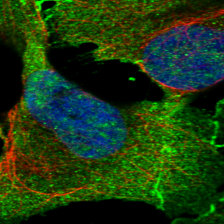

In [166]:
random_view()

Ground Truth
tensor([1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.], dtype=torch.float16)
****************************
tensor([[1.0000e+00, 4.9220e-09, 3.5374e-09, 1.5508e-09, 1.9387e-09, 1.0000e+00,
         1.9515e-09, 5.2299e-09, 1.0000e+00, 7.4993e-09, 2.1314e-09, 2.2764e-09,
         8.6732e-10, 6.1809e-10, 2.8976e-09, 3.1794e-09, 4.1467e-09, 2.5941e-09,
         8.7625e-10]], grad_fn=<SigmoidBackward>)


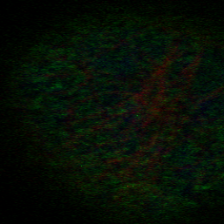

In [168]:
random_view()

Ground Truth
tensor([1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.], dtype=torch.float16)
****************************
tensor([[1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.]], grad_fn=<SigmoidBackward>)


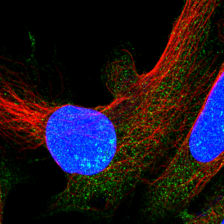

In [169]:
random_view()

Ground Truth
tensor([1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.], dtype=torch.float16)
****************************
tensor([[1.0000e+00, 5.2435e-09, 4.0676e-09, 1.7079e-09, 1.7635e-09, 1.0000e+00,
         2.1769e-09, 5.7999e-09, 1.0000e+00, 8.7840e-09, 2.3520e-09, 2.6883e-09,
         1.0570e-09, 7.0864e-10, 3.0608e-09, 3.7405e-09, 4.3965e-09, 2.6532e-09,
         9.1432e-10]], grad_fn=<SigmoidBackward>)


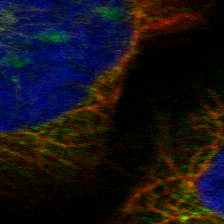

In [170]:
random_view()

Ground Truth
tensor([1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.], dtype=torch.float16)
****************************
tensor([[1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.]], grad_fn=<SigmoidBackward>)


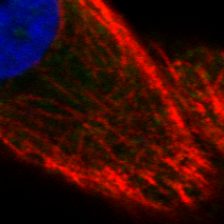

In [171]:
random_view()